In [0]:
!pip install utils

In [0]:
!pip install mxnet

# MxNet  
Apache MXNet is an open-source deep learning software framework, used to train, and deploy deep neural networks. 

# xgboost 
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.


In [0]:
#Libraries
from utils import *
import time
import numpy as np
import pandas as pd
import math
import datetime

#Apache MxNet for Deeplearning Libraries
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [0]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [0]:
import pandas_datareader.data as pdr
import fix_yahoo_finance as fix
import time
fix.pdr_override()

In [0]:
def get_stock_data(ticker, start_date, end_date):
  i = 1
  try:
    all_data = pdr.get_data_yahoo(ticker, start_date, end_date)
  except ValueError:
      print("ValueError, trying again")
      #Add exception logic to get stock data
      #add sleep logic to try again 5 times every 10 secs
  stock_data = all_data["Adj Close"]
  stock_data.to_csv("stock_prices.csv")
  all_data.to_csv("all_stock.csv")

if __name__ == "__main__":
  get_stock_data("GS","2010-01-01", "2019-10-31" )

[*********************100%***********************]  1 of 1 downloaded


In [0]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [0]:
get_stock_data("GS","2010-01-01", "2019-10-31")
dataset_total_df = pd.read_csv("all_stock.csv", header=0, parse_dates=[0], 
                            date_parser=parser)
dataset_ex_df = pd.read_csv("stock_prices.csv", header=0, parse_dates=[0], 
                            date_parser=parser, names=["Date","Price"])
dataset_ex_df.head(10)

[*********************100%***********************]  1 of 1 downloaded


,Date,Price
0,2010-01-05,154.190262
1,2010-01-06,152.544586
2,2010-01-07,155.529587
3,2010-01-08,152.588318
4,2010-01-11,150.181030
5,2010-01-12,146.907074
6,2010-01-13,148.001312
7,2010-01-14,147.528580
8,2010-01-15,144.622345
9,2010-01-19,146.066650


In [0]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2473 number of days in the dataset.


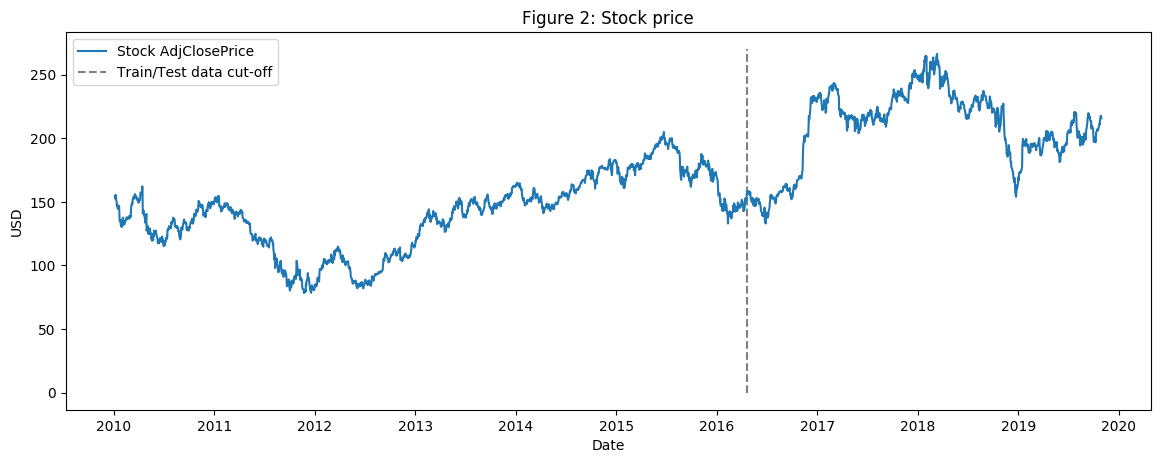

In [0]:
#Visualizing the data for the past 
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Price'], label='Stock AdjClosePrice')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Stock price')
plt.legend()
plt.show()


In [0]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

dataset_ex_df

Number of training days: 1731. Number of test days: 742.


,Date,Price
0,2010-01-05,154.190262
1,2010-01-06,152.544586
2,2010-01-07,155.529587
3,2010-01-08,152.588318
4,2010-01-11,150.181030
...,...,...
2468,2019-10-24,211.050003
2469,2019-10-25,214.229996
2470,2019-10-28,217.750000
2471,2019-10-29,217.639999


# Correlated Assets


# Technical Indicators

Moving average = 7,21

Exponential Moving Average
 that places a greater weight and significance on the most recent data points


**Exponentially weighted moving average** An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations in the period.


The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

In [0]:
def get_technical_ind(dataset):
  #7 and 21 Moving Average
  series = dataset['Close']
  dataset['ma7'] = pd.Series(dataset['Close'].rolling(7, min_periods=1).mean())
  dataset['ma21'] = pd.Series(dataset['Close'].rolling(21, min_periods=1).mean())

  #Create MACD
  dataset['26ema'] = pd.Series(dataset['Close'].ewm(span=26, min_periods=26).mean(),
                               name='EMA_' + str(26))

  dataset['12ema'] = pd.Series(dataset['Close'].ewm(span=12, min_periods=12).mean(),
                               name='EMA_' + str(12))
  dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

  #Create Bolinger Bands
  dataset['20sd'] =  pd.Series(dataset['Close'].rolling(20, min_periods=1).std())
  dataset['upperband'] = dataset['ma21'] + (dataset['20sd']*2)
  dataset['lowerband'] = dataset['ma21'] - (dataset['20sd']*2)

  #Create Exponential moving average
 # dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

  #Create Momentum
  dataset['momentum'] = pd.Series(dataset['Close'].diff(5),
                                name='Momentum_' + str(5))
  #Force Index
  dataset['FI'] = pd.Series(dataset['Close'].diff(5) * 
                            dataset['Volume'], name = 'ForceIndex') 

  return dataset

dataset_TI_df = get_technical_ind(dataset_total_df)
dataset_TI_df =dataset_TI_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'ema', 'ma7'])
dataset_TI_df
#print(dataset_TI_df.head(50))
#plt.plot(dataset_TI_df['Price'], dataset_TI_df['MACD'])
#plt.plot(dataset_TI_df['Price'], dataset_TI_df['momentum'])

,Date,Close,Volume,ma21,26ema,12ema,MACD,20sd,upperband,lowerband,momentum,FI
0,2010-01-04,173.080002,9135000,173.080002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,176.139999,11659400,174.610001,NaN,NaN,NaN,2.163745,178.937490,170.282511,NaN,NaN
2,2010-01-06,174.259995,7381100,174.493332,NaN,NaN,NaN,1.543285,177.579903,171.406761,NaN,NaN
3,2010-01-07,177.669998,8727400,175.287498,NaN,NaN,NaN,2.027467,179.342432,171.232565,NaN,NaN
4,2010-01-08,174.309998,7268100,175.091998,NaN,NaN,NaN,1.809439,178.710875,171.473121,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2469,2019-10-24,211.050003,1266500,204.593811,206.739315,207.541054,0.801739,4.832323,214.258457,194.929164,4.589996,5.813230e+06
2470,2019-10-25,214.229996,2602100,204.880001,207.294180,208.570122,1.275941,5.220933,215.321867,194.438136,7.709992,2.006217e+07
2471,2019-10-28,217.750000,2707800,205.298096,208.068685,209.982411,1.913725,5.968285,217.234667,193.361526,8.500000,2.301630e+07
2472,2019-10-29,217.639999,2030400,205.793811,208.777672,211.160501,2.382830,6.545475,218.884761,192.702861,8.039993,1.632440e+07


In [0]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upperband'],label='Upper Band', color='c')
    plt.plot(dataset['lowerband'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lowerband'], dataset['upperband'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()
  


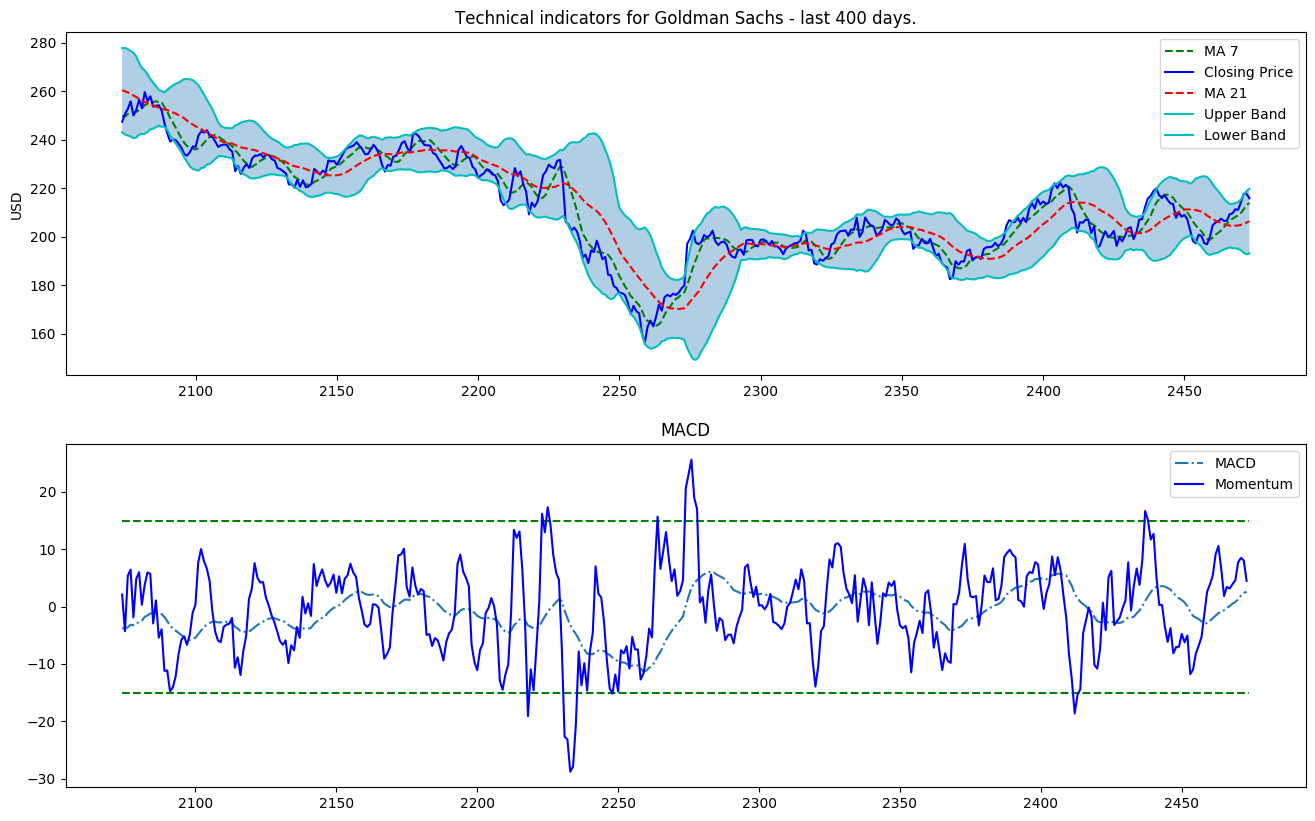

In [0]:
plot_technical_indicators(dataset_TI_df, 400)



# Fundamental Analysis
Sentiment analysis for GS
# 1. Bidirectional Embeddinf Representation from Transformers - BERT

Pre trained language representation.
Available on MXNet/Gluon.
instantiate and add dense layers - score from 0 to 1

# Fourier Transforms for trend analysis

  Fourier transforms take a function and create a series of sine waves (with different amplitudes and frames). When combined, these sine waves approximate the original function

       We will use Fourier transforms to extract global and local trends in the GS stock, and to also denoise it a little. So let's see how it works.



In [0]:
data_FT = dataset_ex_df[['Date', 'Price']]

close_fft = np.fft.fft(np.asarray(data_FT['Price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))


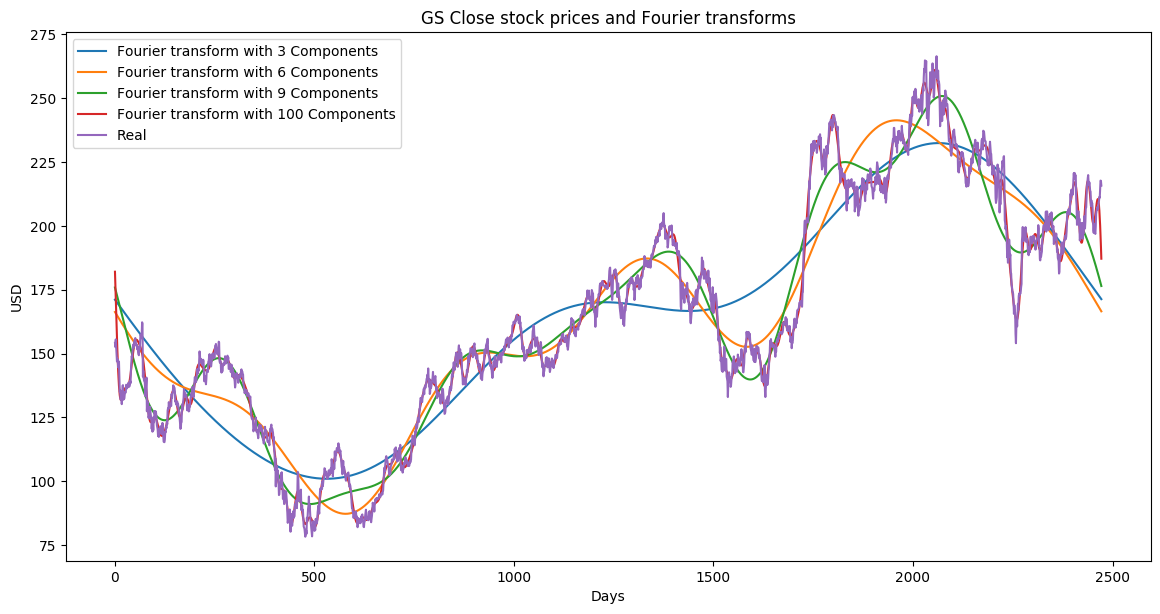

In [0]:
plt.figure(figsize=(14,7), dpi=100)
fft_list = np.asarray(fft_df['fft'].to_list())
for num in [3,6,9,100]:
  fft_list_m10=np.copy(fft_list)
  fft_list_m10[num:-num]=0
  plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} Components'.format(num))

plt.plot(data_FT['Price'], label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('GS Close stock prices and Fourier transforms')
plt.legend()
plt.show()


  Another technique used to denoise data is call wavelets. Wavelets and Fourier transform gave similar results so we will only use Fourier transforms.



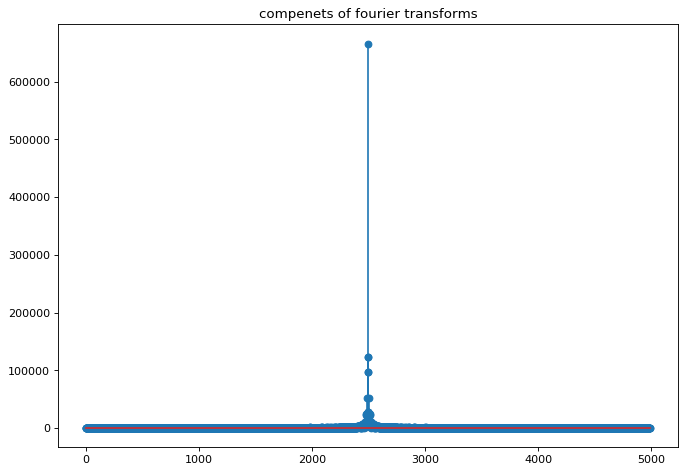

In [0]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].to_list()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10,7), dpi=80)
plt.stem(items)
plt.title('compenets of fourier transforms')
plt.show()

# ARIMA
  ARIMA is a technique for predicting time series data. We will show how to use it, and althouth ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.
  

In [0]:
from statsmodels.tsa.arima_model import ARIMA

series = data_FT['Price']
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 4987
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11963.993
Method:                       css-mle   S.D. of innovations              2.665
Date:                Sat, 23 Nov 2019   AIC                          23941.987
Time:                        17:50:59   BIC                          23987.589
Sample:                             1   HQIC                         23957.972
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0299      0.034      0.868      0.385      -0.038       0.097
ar.L1.D.Price    -0.0408      0.014     -2.883      0.004      -0.069      -0.013
ar.L2.D.Price    -0.0116      0.014     

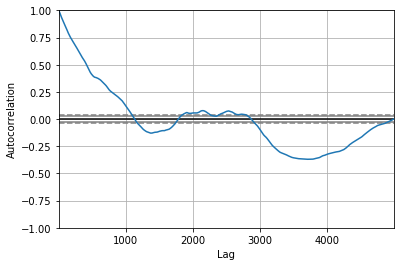

<Figure size 800x560 with 0 Axes>

In [0]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10,7),dpi=80)
plt.show()


In [0]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X)*0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
  model =  ARIMA(history, order=(5,1,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)

error = mean_squared_error(test, predcitions)
print('Test MSE: %.3f'%error)


KeyboardInterrupt: ignored

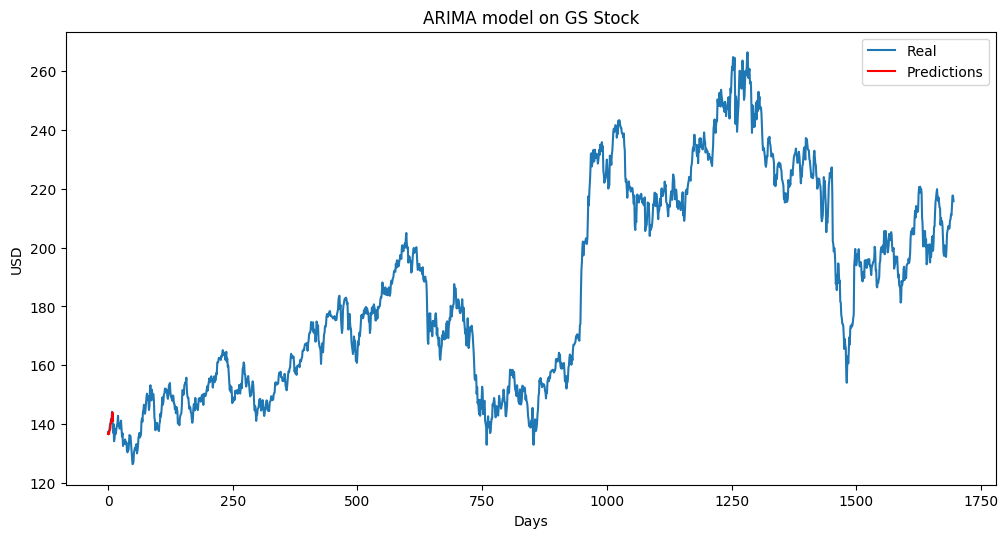

In [0]:
#plot the redicted ARIMA vs real prices

plt.figure(figsize=(12,6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predictions')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on GS Stock')
plt.legend()
plt.show()

# Feature Engineering



In [0]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))


Total dataset has 4989 samples, and 7 features.


In [0]:
def get_feature_importance(data_input):
  data = data_input.copy()
  y=data['Close']
  X=data.iloc[:,2:]
  train_s = int(X.shape[0]*0.65)

  X_train = X.iloc[:train_s]
  X_test = X.iloc[train_s:]

  y_train = y.iloc[:train_s]
  y_test = y.iloc[train_s:]

  return (X_train, y_train), (X_test, y_test)

print(dataset_TI_df.corr())
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance(dataset_TI_df)

regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150, base_score=0.7,colsample_bytree=1,learning_rate=0.05)

xgbModel = regressor.fit(X_train_FI, y_train_FI, eval_set=[(X_train_FI, y_train_FI),(X_test_FI, y_test_FI)],
                         verbose=False)

eval_res = regressor.evals_result()
training_rounds = range(len(eval_res['validation_0']['rmse']))

              Close    Volume      ma21  ...  lowerband  momentum        FI
Close      1.000000 -0.286555  0.986393  ...   0.981469  0.078961  0.063385
Volume    -0.286555  1.000000 -0.256392  ...  -0.281977 -0.163083 -0.604657
ma21       0.986393 -0.256392  1.000000  ...   0.993863 -0.045135 -0.016688
26ema      0.987453 -0.265964  0.999197  ...   0.992781 -0.039044 -0.013924
12ema      0.994728 -0.268336  0.997210  ...   0.991703 -0.011501  0.004568
MACD       0.207846 -0.161898  0.083765  ...   0.094691  0.349021  0.215917
20sd       0.182475  0.190423  0.195149  ...   0.085459 -0.034228 -0.087531
upperband  0.979755 -0.229000  0.994368  ...   0.976542 -0.047625 -0.025691
lowerband  0.981469 -0.281977  0.993863  ...   1.000000 -0.041996 -0.007091
momentum   0.078961 -0.163083 -0.045135  ...  -0.041996  1.000000  0.604767
FI         0.063385 -0.604657 -0.016688  ...  -0.007091  0.604767  1.000000

[11 rows x 11 columns]
[22:07:35] WARNING: /workspace/src/objective/regression_obj.cu:1

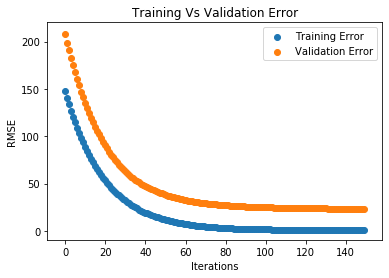

In [0]:
plt.scatter(x=training_rounds,y=eval_res['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_res['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

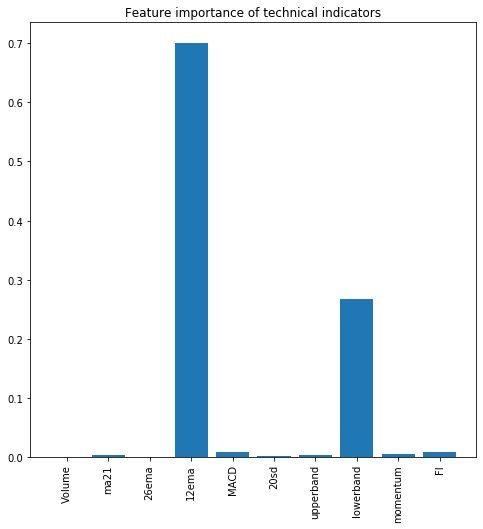

In [0]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], 
        xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Feature importance of technical indicators')
plt.show()

No handles with labels found to put in legend.


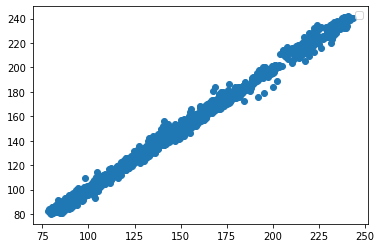

In [0]:

plt.scatter(x=y_train_FI,y=X_train_FI['ma7'])

plt.legend()
plt.show()


# Stacked AutoEncoder

Gaussian Error Linear Unites was recently proposed. In the paper the authors show several instances in which neural networks using GELU outperform networks using ReLU as an activation. gelu is also used in BERT, the NLP approach we used for news sentiment analysis.

       We will use GELU for the autoencoders.

Note: The cell below shows the logic behind the math of GELU. It is not the actual implementation as an activation function. I had to implement GELU inside MXNet. If you follow the code and change act_type='relu' to act_type='gelu' it will not work, unless you change the implementation of MXNet. Make a pull request on the whole project to access the MXNet implementation of GELU